In [1]:
import sys
sys.path.append("..")

In [2]:
import wfdb

from raccoon.utils.annotationutils import trigger_points

def read_record(path, sampto):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    positions, labels = trigger_points(annotation, with_labels=True)
    return record, positions, labels

def read_records(directory, names, sampto):
    records, positions, labels = [], [],  []
    for name in names:
        path = "/".join([directory, name])
        record, pos, labs = read_record(path, sampto)
        records.append(record)
        positions.append(pos)
        labels.append(labs)
    return records, positions, labels

In [3]:
record_dir = "../physionet.org/files/mitdb/1.0.0"
test_path = '/'.join([record_dir, '106'])
train_names = ["100", "101", "102", "103", "104"]
sampto = None

train_records, train_positions, train_labels = read_records(record_dir, train_names, sampto)
test_record, test_positions, test_labels = read_record(test_path, sampto)

In [4]:
from raccoon.detectors import GarciaBerdonesDetector

detector = GarciaBerdonesDetector(
    name = "GarciaBerdones01",
    batch_size = 32,
    window_size = 20,
    epochs = 3)

detector.train(train_records, train_positions)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
101559/101559 [==============================] - 126s 1ms/step - loss: 0.0284
Epoch 2/3
101559/101559 [==============================] - 126s 1ms/step - loss: 0.0257
Epoch 3/3
101559/101559 [==============================] - 125s 1ms/step - loss: 0.0273


In [5]:
trigger_signal = detector.trigger_signal(test_record)

In [6]:
from raccoon.utils.triggerutils import signal_to_points

detections, certainties = signal_to_points(trigger_signal, with_certainty=True)

In [7]:
cert_dict = dict(zip(detections, certainties))
label_dict = dict(zip(test_positions, test_labels))

In [8]:
from raccoon.utils.evaluationutils import merge
import pandas as pd

df = pd.DataFrame(
    list(merge(test_positions, detections, tolerance=3)),
    columns=["Position", "Detection", "Error"])

df["Certainty"] = df.Detection.map(cert_dict)
df["Label"] = df.Position.map(label_dict)

In [9]:
df.head(50)

,Position,Detection,Error,Certainty,Label
0,351.0,351.0,TP,0.998074,N
1,724.0,725.0,TP,0.998105,N
2,1086.0,1086.0,TP,0.998519,N
3,1448.0,1448.0,TP,0.998382,N
4,1829.0,1829.0,TP,0.989859,N
5,2197.0,2197.0,TP,0.994814,N
6,2571.0,2573.0,TP,0.845612,N
7,2918.0,2919.0,TP,0.998754,N
8,3234.0,3234.0,TP,0.998839,N
9,3571.0,3571.0,TP,0.995001,N


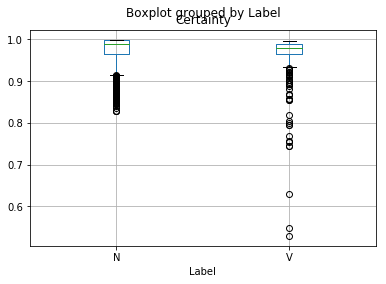

In [10]:
df.boxplot(column='Certainty', by='Label')

In [11]:
from scipy.stats import ttest_ind

ttest_ind(df[df.Label == 'N'].Certainty, df[df.Label == 'V'].Certainty, nan_policy='omit')

Ttest_indResult(statistic=4.517632433932821, pvalue=6.634882561136429e-06)

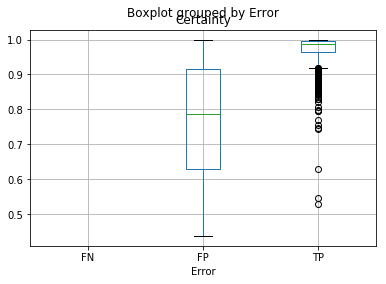

In [12]:
df.boxplot(column='Certainty', by='Error')

In [13]:
ttest_ind(df[df.Error == 'TP'].Certainty, df[df.Error == 'FP'].Certainty, nan_policy='omit')

Ttest_indResult(statistic=48.097079582852146, pvalue=0.0)